In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import sys
from pathlib import Path 

import struct
from array import array

%matplotlib inline

sns.set_theme(style='whitegrid')

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

try:
    parent_dir = Path(__file__).resolve().parent.parent
except NameError:
    parent_dir = Path.cwd().parent
    
sys.path.append(str(parent_dir))
from MLP import NeuralNetwork, accuracy, cross_entropy

### Подготовка данных

In [ ]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())   

        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        X_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        X_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (X_train, y_train),(X_test, y_test)  
    
    
training_images_filepath = '../data/mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = '../data/mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = '../data/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = '../data/mnist-dataset/t10k-labels.idx1-ubyte'

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(X_train, y_train), (X_test, y_test) = mnist_dataloader.load_data()

def normalize(X):
    X_normalize = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X_normalize   

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)]) 

X_train = normalize(np.array([np.ravel(x) for x in X_train]))
X_test = normalize(np.array([np.ravel(x) for x in X_test]))
 
y_train = np.array([one_hot(np.array(y, dtype=int), 10) for y in y_train], dtype=int)
y_test = np.array([one_hot(np.array(y, dtype=int), 10) for y in y_test], dtype=int)

input_size = X_train.shape[1]
output_size = y_train.shape[1]

### Обучение и предсказание

In [12]:
model = NeuralNetwork(layer_sizes=[input_size, 100, 200, output_size], 
                      activation='relu', 
                      task='classification')

losses = model.train(X_train, y_train, epochs=50, batch_size=64, learning_rate=0.01)

y_pred_probs = model.predict(X_test)
test_acc = accuracy(y_test, y_pred_probs)

print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 97.45%


### Визуализация

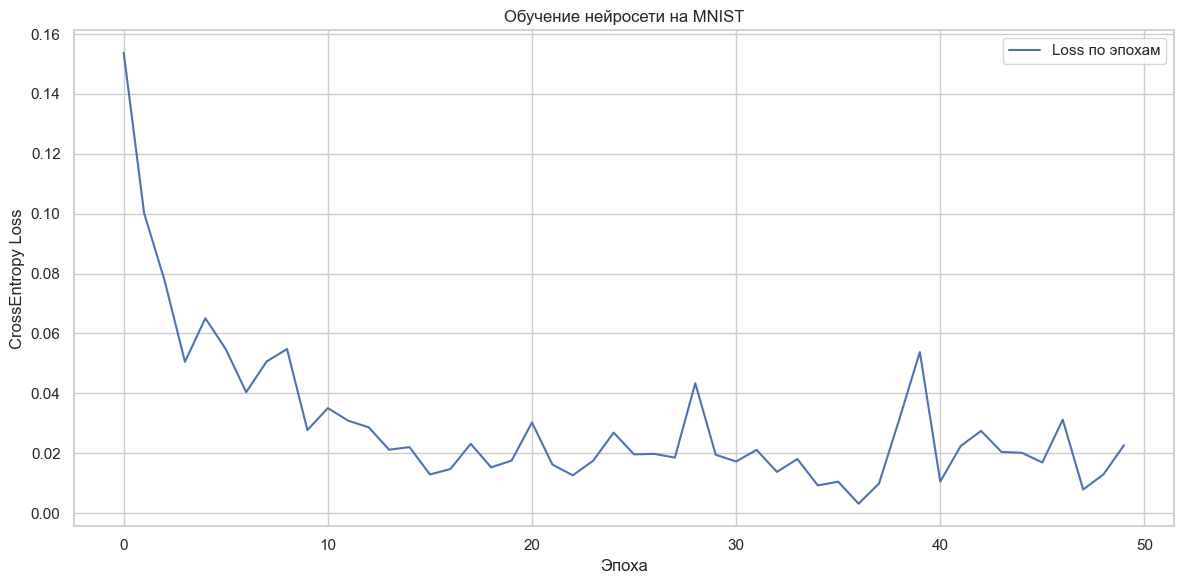

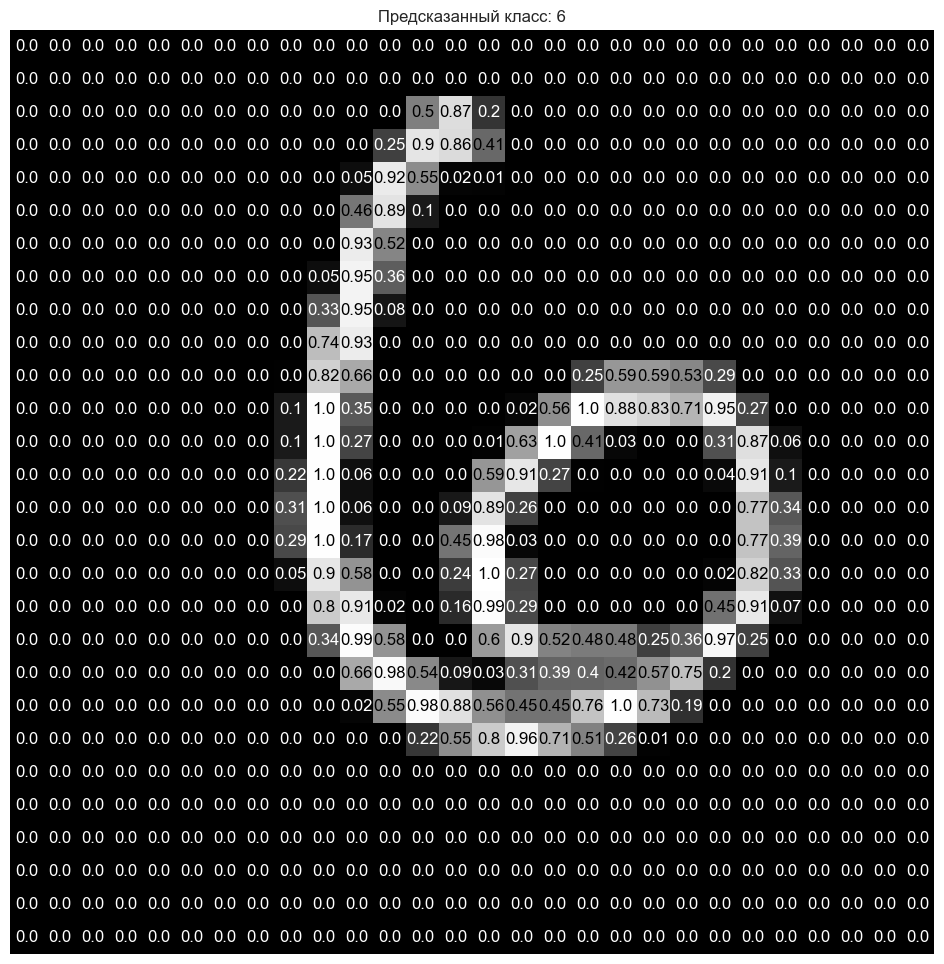

In [13]:
plt.plot(losses, label="Loss по эпохам")
plt.title("Обучение нейросети на MNIST")
plt.xlabel("Эпоха")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

def visualize_input(img, ax):
    img_reshaped = img.reshape(28, 28)
    ax.imshow(img_reshaped, cmap='gray')
    width, height = img_reshaped.shape
    thresh = img_reshaped.max() / 2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img_reshaped[x][y], 2)), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img_reshaped[x][y] < thresh else 'black')

fig = plt.figure(figsize=(12, 12)) 
ax = fig.add_subplot(111)
visualize_input(X_test[100], ax)
plt.title(f"Предсказанный класс: {np.argmax(y_pred_probs[100])}")
plt.axis('off')
plt.show()